# **Laboratorio 2 - Visión por Computadora**

- Paula Barillas - 22764
- Gerardo Pineda - 22880
- Mónica Salvatierra - 22249

Link del repositorio: https://github.com/paulabaal12/LAB2-VCP

## **Task 1**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import os
from skimage import io, color, filters, morphology, util

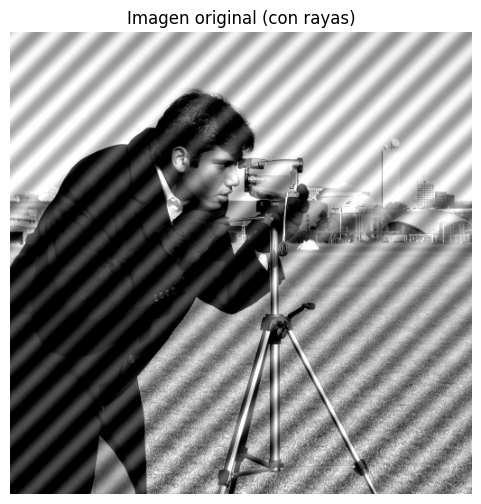

In [2]:
img = cv2.imread("img/periodic_noise.jpg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se encontró periodic_noise.jpg (revisa la ruta).")

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title("Imagen original (con rayas)")
plt.axis("off")
plt.show()


### **DFT + desplazar componente DC al centro**

In [3]:
img_f = img.astype(np.float32)


F = np.fft.fft2(img_f)
Fshift = np.fft.fftshift(F)


### **Espectro de magnitud**

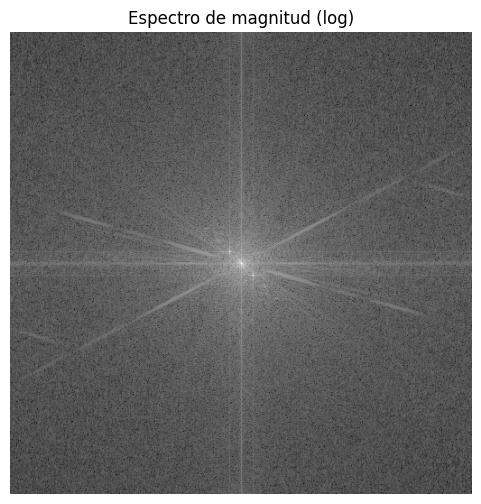

In [4]:

mag_log = np.log1p(np.abs(Fshift))

plt.figure(figsize=(6,6))
plt.imshow(mag_log, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")
plt.show()



### **Picos de energía que no contribuyen a la información natural de la imagen**
Usamos detección de líneas para encontrar las rayas brillantes que causan el patrón diagonal.

In [5]:
h, w = mag_log.shape
cy, cx = h//2, w//2

safe = mag_log.copy()

# Quitar centro
Y, X = np.ogrid[:h, :w]
r0 = int(0.06 * min(h, w))
safe[(Y-cy)**2 + (X-cx)**2 <= r0**2] = 0

# Quitar cruz
band = 10
safe[:, cx-band:cx+band] = 0
safe[cy-band:cy+band, :] = 0

# Tomar 10 más brillantes
N = 10
flat_indices = np.argpartition(safe.ravel(), -N)[-N:]
coords = np.column_stack(np.unravel_index(flat_indices, safe.shape))

# Ordenar por intensidad
coords = sorted(coords, key=lambda c: safe[c[0], c[1]], reverse=True)

# Nos quedaremos con los 2 más fuertes
peaks = np.array(coords[:2])

print("Picos usados:", peaks)




Picos usados: [[282 282]
 [230 230]]


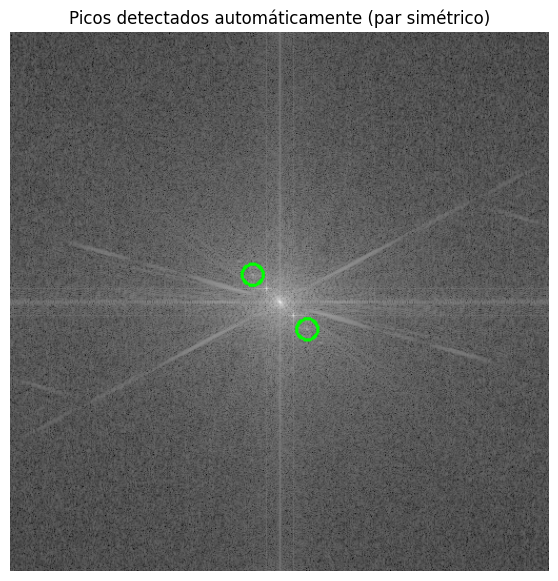

In [6]:
view = cv2.normalize(mag_log, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
view = cv2.cvtColor(view, cv2.COLOR_GRAY2BGR)

for py, px in peaks:
    cv2.circle(view, (px, py), 10, (0,255,0), 2)

plt.figure(figsize=(7,7))
plt.imshow(view[..., ::-1])
plt.title("Picos detectados automáticamente (par simétrico)")
plt.axis("off")
plt.show()



### **Máscara Notch Filter**
Bloqueamos específicamente los picos de frecuencia detectados, pero preservamos el componente DC.

In [7]:
H = np.ones((h, w), dtype=np.float32)
radius = 24

Y, X = np.ogrid[:h, :w]

for py, px in peaks:
    sy, sx = 2*cy - py, 2*cx - px

    H[(Y-py)**2 + (X-px)**2 <= radius**2] = 0
    H[(Y-sy)**2 + (X-sx)**2 <= radius**2] = 0



### **Aplicación Notch Filter e IDFT**

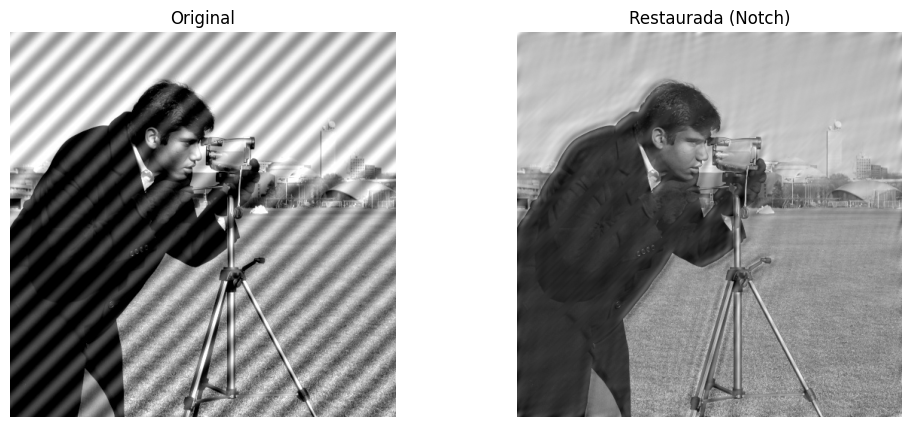

In [8]:
F_filtered = Fshift * H

img_back = np.fft.ifft2(np.fft.ifftshift(F_filtered))
img_back = np.real(img_back)

img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_back = img_back.astype(np.uint8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_back, cmap="gray")
plt.title("Restaurada (Notch)")
plt.axis("off")
plt.show()





Responde aquí no

## **Task 2**

In [9]:
img = io.imread("img/fingerprint_noisy.png")

Nos aseguramos que la imagen sea binaria 

In [10]:
t = filters.threshold_otsu(img)
bin_img = img > t 

Elección de operaciones morfológicas

In [11]:
# Apertura para quitar puntitos blancos 
selem_open = morphology.disk(1)  

# Cierre para conectar grietas pequeñas en crestas
selem_close = morphology.disk(2) 

# eliminar ruido blanco 
step2 = morphology.opening(bin_img, selem_open)

# conectar grietas
final_img = morphology.closing(step2, selem_close)


Mostrar operación original

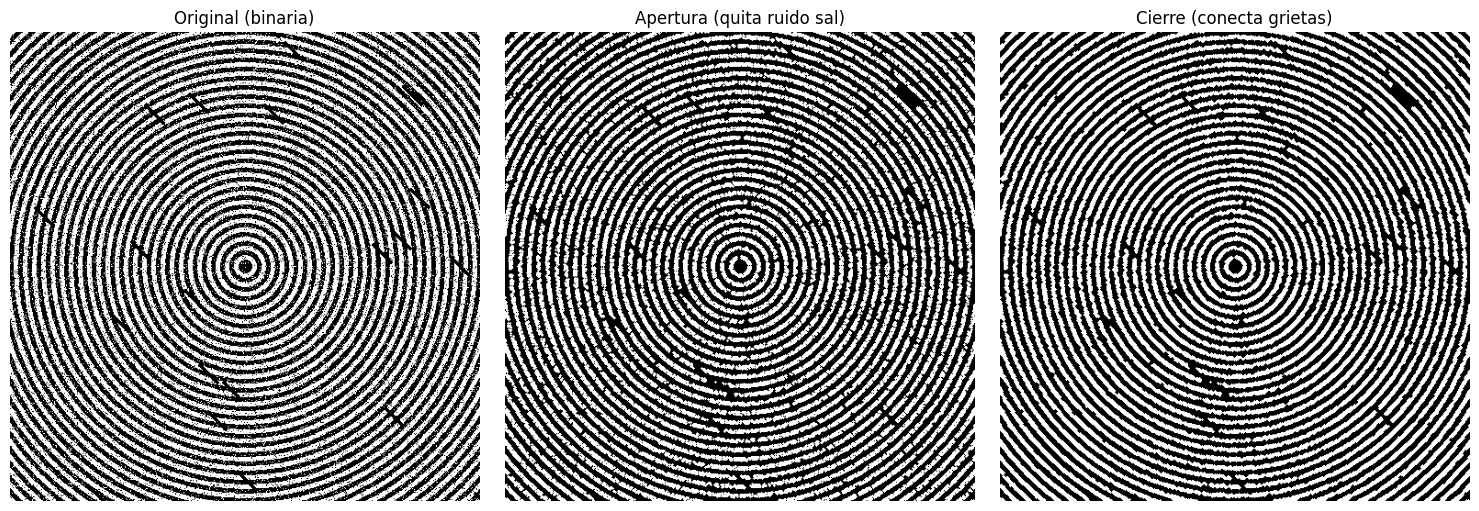

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bin_img, cmap="gray")
ax[0].set_title("Original (binaria)")
ax[0].axis("off")

ax[1].imshow(step2, cmap="gray")
ax[1].set_title("Apertura (quita ruido sal)")
ax[1].axis("off")

ax[2].imshow(final_img, cmap="gray")
ax[2].set_title("Cierre (conecta grietas)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Mostrar operación inversaS

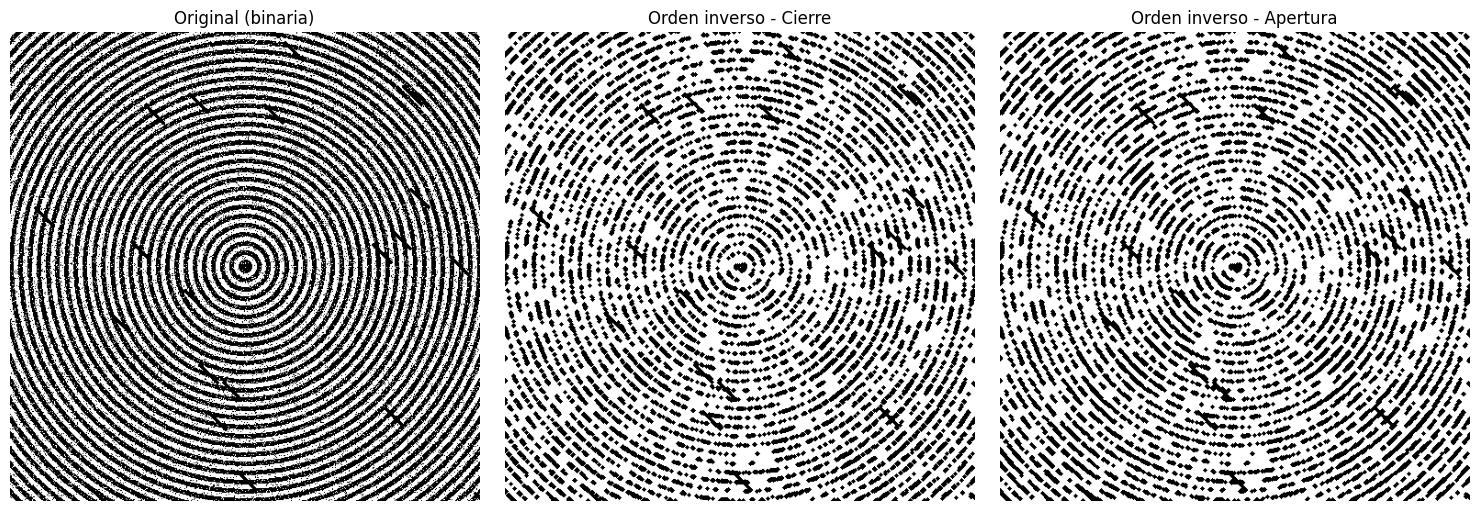

In [13]:
inv_step2 = morphology.closing(bin_img, selem_close)
inv_final = morphology.opening(inv_step2, selem_open)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bin_img, cmap="gray")
ax[0].set_title("Original (binaria)")
ax[0].axis("off")

ax[1].imshow(inv_step2, cmap="gray")
ax[1].set_title("Orden inverso - Cierre")
ax[1].axis("off")

ax[2].imshow(inv_final, cmap="gray")
ax[2].set_title("Orden inverso - Apertura")
ax[2].axis("off")

plt.tight_layout()
plt.show()


**¿El orden de los factores altera el producto? Explique qué hubiera pasado si hubiera
aplicado las operaciones en orden inverso y demuéstrelo con un ejemplo visual en el notebook.**

- El orden de las operaciones morfólogicas alteran el resultado final. En este caso, las operaciones de apertura y cierre no son conmutativas, por lo que el resultado se ve afectando en el orden en el que se aplican (tal como se observa en las imagenes generadas arriba).

    En el caso de la primera fila, la apertura sirve para eliminar el ruido sal, sin afectar de manera significativa la estructura de las crestas. Posteriormente, el cierre rellena las grietas y conecta discontinuidades en las crestas, de tal manera que pueda generar una imagen mucho más limpia.

    Por otro lado, en la segunda fila se observa que en el cierre, se engrosan un poco las crestas e integra cierto ruido blanco a la estructura principal. Luego, la apertura eliminar detalles finos o romper conexiones delgadas que el cierre acababa de formar, generando una imagen más fragmentada y menos uniforme.

    El orden inverso produce una textura más discontinua y menos limpia que el orden correcto. Por lo tanto, el orden de aplicación sí influye directamente en la calidad del resultado final.

## **Task 3**

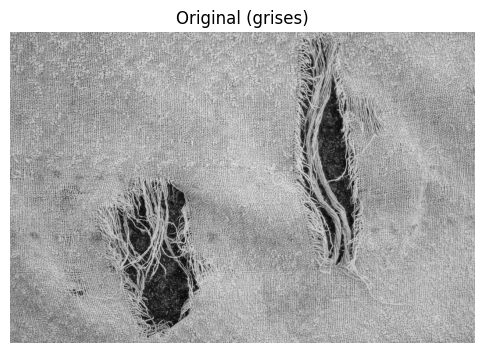

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, title="", cmap="gray"):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

img = cv2.imread("img/image.png", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No pude leer la imagen. Revisa PATH.")

img_f = img.astype(np.float32) / 255.0
show(img, "Original (grises)")


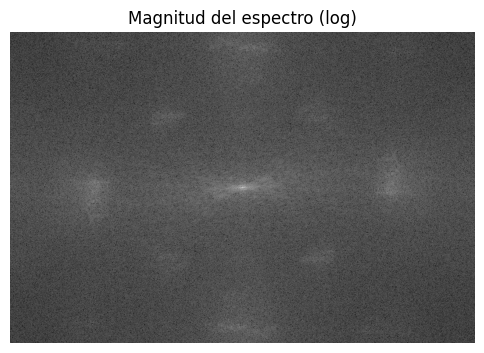

In [15]:
#FFT
F = np.fft.fft2(img_f)
Fshift = np.fft.fftshift(F)
mag = np.log1p(np.abs(Fshift))

show(mag, "Magnitud del espectro (log)")


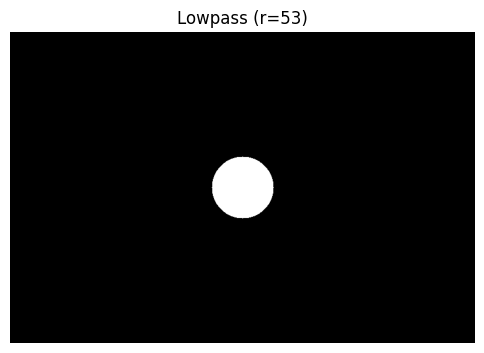

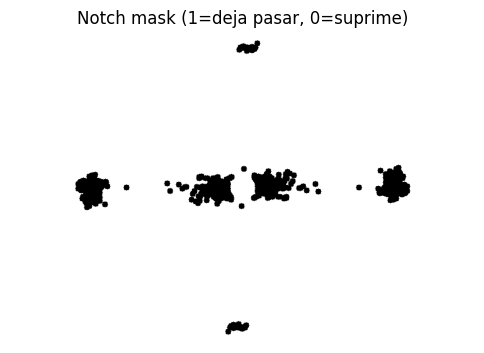

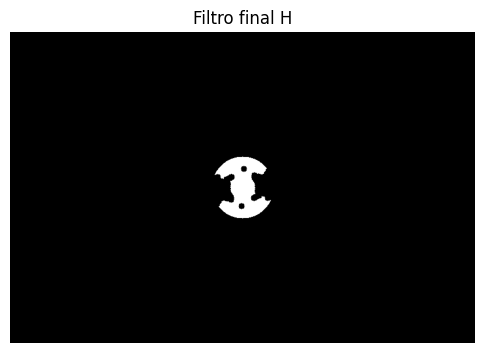

In [16]:
# FFT
h, w = img.shape
cy, cx = h // 2, w // 2
Y, X = np.ogrid[:h, :w]
dist2 = (Y - cy) ** 2 + (X - cx) ** 2

r = int(0.10 * min(h, w)) 
lowpass = (dist2 <= r * r).astype(np.float32)

use_notch = True
notch = np.ones((h, w), np.float32)

if use_notch:
    center_exclusion = int(0.05 * min(h, w))
    safe = mag.copy()
    safe[dist2 < center_exclusion**2] = 0

    thr = np.percentile(safe, 99.7)       
    peaks = np.argwhere(safe > thr)
    notch_radius = max(3, int(0.01 * min(h, w)))

    for (py, px) in peaks:
        cv2.circle(notch, (int(px), int(py)), notch_radius, 0, -1)
        sy = int(2 * cy - py)
        sx = int(2 * cx - px)
        if 0 <= sy < h and 0 <= sx < w:
            cv2.circle(notch, (sx, sy), notch_radius, 0, -1)

H = lowpass * notch

show(lowpass, f"Lowpass (r={r})")
show(notch, "Notch mask (1=deja pasar, 0=suprime)")
show(H, "Filtro final H")


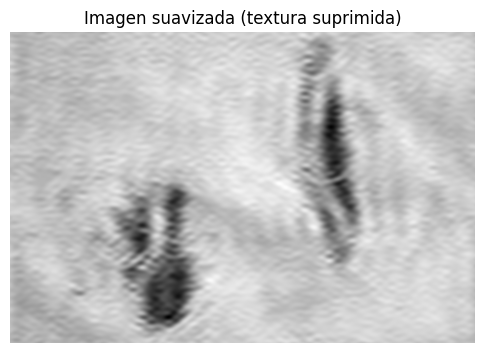

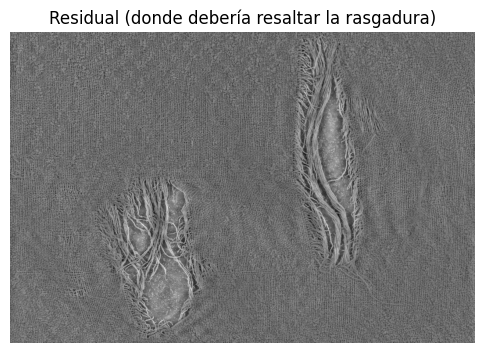

In [17]:
#Threshold 
F_filt = Fshift * H
img_smooth = np.fft.ifft2(np.fft.ifftshift(F_filt))
img_smooth = np.real(img_smooth)

img_smooth = (img_smooth - img_smooth.min()) / (img_smooth.max() - img_smooth.min() + 1e-9)

residual = img_f - img_smooth
residual = (residual - residual.min()) / (residual.max() - residual.min() + 1e-9)

show(img_smooth, "Imagen suavizada (textura suprimida)")
show(residual, "Residual (donde debería resaltar la rasgadura)")


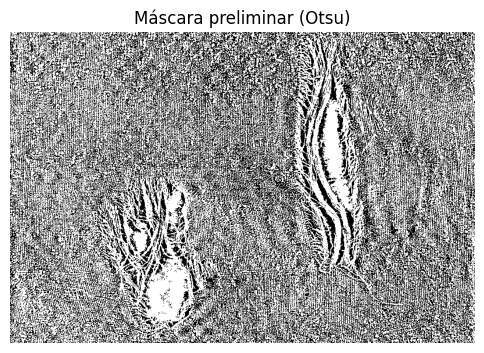

In [18]:
res8 = (residual * 255).astype(np.uint8)

invert = False

if not invert:
    _, mask0 = cv2.threshold(res8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
else:
    _, mask0 = cv2.threshold(res8, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

show(mask0, "Máscara preliminar (Otsu)")


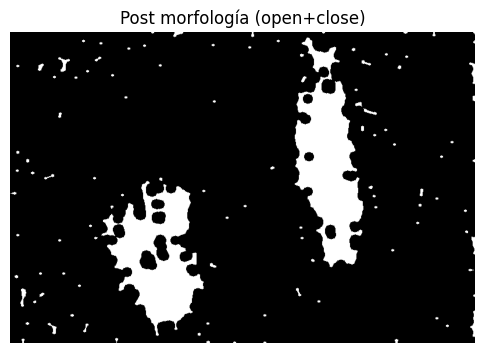

In [19]:
k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

mask = cv2.morphologyEx(mask0, cv2.MORPH_OPEN, k1, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k2, iterations=2)

show(mask, "Post morfología (open+close)")


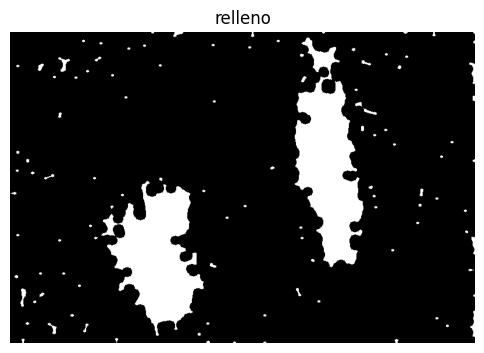

In [20]:
# Fill holes
flood = mask.copy()
h2, w2 = mask.shape
cv2.floodFill(flood, np.zeros((h2 + 2, w2 + 2), np.uint8), (0, 0), 255)
holes = cv2.bitwise_not(flood)
mask_filled = cv2.bitwise_or(mask, holes)

show(mask_filled, "relleno")

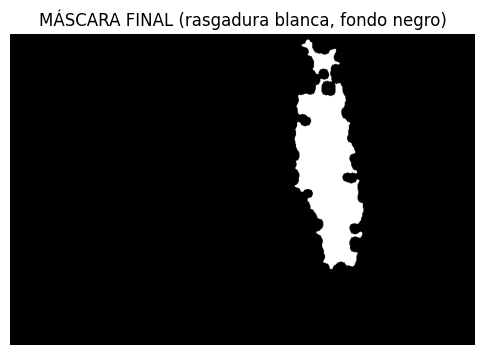

In [21]:
# Componente conectado más grande
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_filled, connectivity=8)
if num_labels > 1:
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    final_mask = np.where(labels == largest, 255, 0).astype(np.uint8)
else:
    final_mask = mask_filled

show(final_mask, "MÁSCARA FINAL (rasgadura blanca, fondo negro)")

uno de los trade off se encuentran al usar la frecuencia para quitar la textura de la tela, esta funciona cuando la parte rasgada es clara y relativamente grande, porque resalta. Pero, si la rasgadura es muy pequeña o muy delgada, puede perderse (como se mira en el ejercicio, que la rasgadura mas grande se quedo y la pequeña se quito), ya que el filtrado y la suavización también eliminan detalles finos. Si  se llegara a cambiar el tipo de tela, que tenga patrones o textura, el filtro puede que no funcione igual y puede pasar que aparezca mas ruido, por eso no es muy confible la solucion y no funcionaria en cualquier imagen.

## **Prompt Utilizado**



### Por qué funcionó este prompt


como interpreto el espectro de Fourier de una imagen con textura de tela y una rasgadura?
¿Qué pasa si cambiamos el tipo de tela? 